# Spectrum changes with single lens imaging

At first, the pupil flane in frequency domain should be reveal.

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io as sio
from skimage.transform import resize
import os
import numpy as np
import sys
import imp
sys.path.append("D:\\Workspace\\git_proj\\CCCode")
import imaging_process
imp.reload(imaging_process)
from imaging_process import ft2, ift2, Wavefront, tie_solution, img_val_norm, Check

PIXEL_SIZE = 5e-6
PIXEL_NUM = 512
WAVELENGTH = 500e-9

In [2]:
# import images
imgs_path = "D:\\Workspace\\datasets\\open_image_val_standard"
imgs_name_list = os.listdir(imgs_path)[0:2]
imgs_fpath_list = [os.path.join(imgs_path, img_name) for img_name in imgs_name_list]
amp_img = img_val_norm(resize(sio.imread(imgs_fpath_list[0]), (PIXEL_NUM, PIXEL_NUM)), 0.8, 1)
pha_img = img_val_norm(resize(sio.imread(imgs_fpath_list[1]), (PIXEL_NUM, PIXEL_NUM)), 0.2, 1.5)

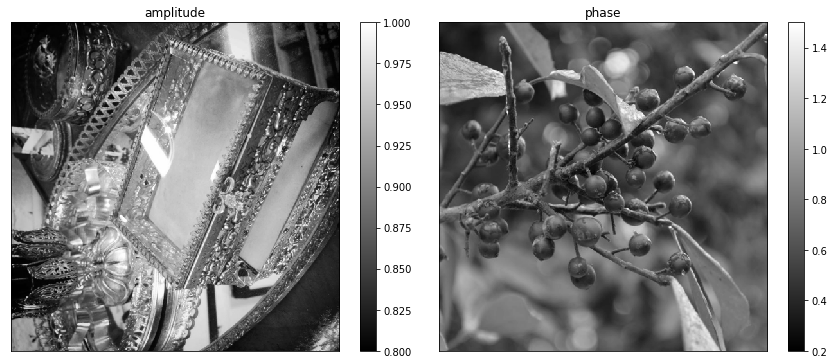

In [10]:
# plt.figure(figsize=[10, 4])
# plt.subplot(121)
# plt.imshow(amp_img, cmap="gray")
# plt.title("amplitude")
# plt.colorbar()
# plt.subplot(122)
# plt.imshow(pha_img, cmap="gray")
# plt.title("phase")
# plt.colorbar()
# plt.tight_layout()
# plt.show()
Check.multi_img(amplitude=amp_img, phase=pha_img)

In [36]:
import imaging_process
imp.reload(imaging_process)
from imaging_process import ft2, ift2, Wavefront, tie_solution, img_val_norm, Check

ff = 50e-3
d1 = 2*ff
d2 = 2*ff

wf_obj = Wavefront.from_bioimage(amp_img, pha_img, WAVELENGTH, PIXEL_SIZE)
pre_lens_ft, imaging_ft, imaging_pl_focus = wf_obj.lens_transfer(d1=d1, focus=ff, d2=d2, relative_na=1.)

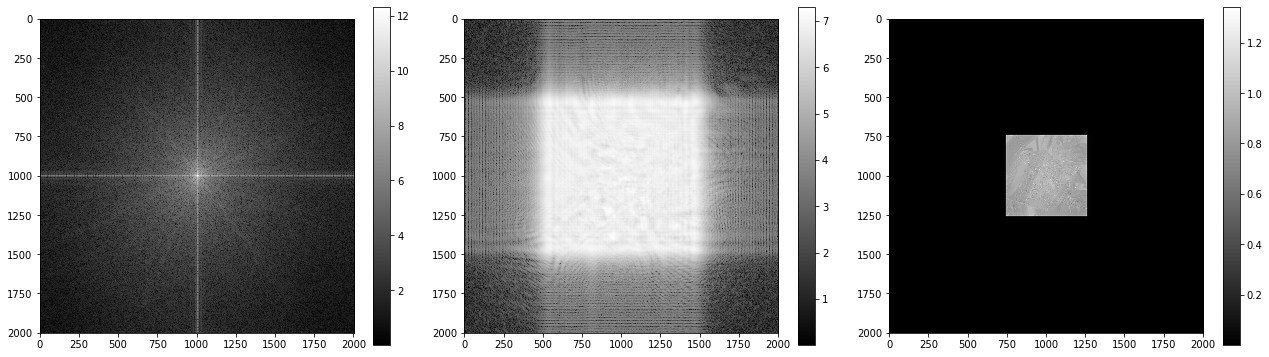

In [41]:
plt.figure(figsize=[18, 5])
plt.subplot(131)
plt.imshow(np.log(1+abs(pre_lens_ft)), cmap="gray")
plt.colorbar()
plt.subplot(132)
plt.imshow(np.log(1+abs(imaging_ft)), cmap="gray")
plt.colorbar()
plt.subplot(133)
plt.imshow(abs(ift2(imaging_ft)), cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()